<a href="https://colab.research.google.com/github/camilla-scandola/project-shark-attack/blob/main/quest_sharkatack.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install pandas

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install openpyxl

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install xlrd

Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install pycountry

Note: you may need to restart the kernel to use updated packages.


In [5]:
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt

In [6]:
df = pd.read_excel('GSAF5.xls')

In [7]:
pd.set_option('display.max_columns', None)
df.head()

,Date,Year,Type,Country,State,Location,Activity,Name,Sex,Age,Injury,Fatal Y/N,Time,Species,Source,pdf,href formula,href,Case Number,Case Number.1,original order,Unnamed: 21,Unnamed: 22
0,16th August 2025,2025.0,Provoked,USA,Florida,Cayo Costa Boca Grande,Fishing,Shawn Meuse,M,?,Laceration to right leg below the knee,N,1055 hrs,Lemon shark 1.8 m (6ft),Johannes Marchand: Kevin McMurray Trackingshar...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,18th August,2025.0,Unprovoked,Australia,NSW,Cabarita Beach,Surfing,Brad Ross,M,?,None sustained board severly damaged,N,0730hrs,5m (16.5ft) Great White,Bob Myatt GSAF The Guardian: 9 News: ABS News:...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,17th August,2025.0,Unprovoked,Bahamas,Atlantic Ocean near Big Grand Cay,North of Grand Bahama near Freeport,Spearfishing,Not stated,M,63,Severe injuries no detail,N,1300hrs,Undetermined,Ralph Collier GSAF and Kevin MCMurray Tracking...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,7th August,2025.0,Unprovoked,Australia,NSW,Tathra Beach,Surfing,Bowie Daley,M,9,None sustained board severely damaged,N,1630hrs,Suspected Great White,Bob Myatt GSAF,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1st August,2025.0,Unprovoked,Puerto Rico,Carolina,Carolina Beach,Wading,Eleonora Boi,F,39,Bite to thigh area,N,Not stated,Undetermined,Kevin McMurray Trackingsharks.com: NY Post,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
#delete empty columns

df = df.drop(columns=[col for col in ["pdf", "href formula", "href", "Case Number", "Case Number.1", "original order", "Unnamed: 21", "Unnamed: 22"] if col in df.columns])

I started analyzing the dataset by country, state, and location, since the first two play a key role in understanding the overall risks of surfing worldwide. For the country column, only 50 entries are missing out of a 7,041 total, so these rows can be dropped without affecting the analysis.
For state and location, however, the number of missing values is much higher. Instead of dropping them (which would remove too much data), I replaced all missing entries with "undefined"

In [9]:
#overview of missing values by country, state, location

missing_country = int(df['Country'].isna().sum())
print(f"Missing country values: {missing_country}")

missing_state = int(df['State'].isna().sum())
print(f"Missing state values: {missing_state}")

missing_location = int(df['Location'].isna().sum())
print(f"Missing location values: {missing_location}")

print(df.shape)

#suggestion: drop all the null values under country (because they won't make a big difference in the analysis, being 50 out of 7041)

df = df.dropna(subset=['Country'])

Missing country values: 50
Missing state values: 485
Missing location values: 567
(7042, 15)


In [10]:
#suggestion: the number of missing values in states and locations is a lot more significant, so I'd replace them with undefined for the time being

df['State'] = df['State'].fillna('undefined')

df['Location'] = df['Location'].fillna('undefined')

I decided to use pycountry to clean the country column. However, I had to be cautious to avoid losing meaningful data. To do this, I created a mapping dictionary to replace the current country names with the standardized ones from pycountry (using AI to help detect all possible variants and mismatches by comparing the initial list of countries with the pycountry-filtered list).

In addition, I filtered out any entries referring to seas or oceans, since these are not valid countries. To ensure I did not discard relevant information, I added code to check whether any of the accidents in rows containing ocean or sea were related to surfing (see below)

In [11]:
#imported pycountry to filter out all entries that do not correspond to standard countries

import pycountry

#cleaning format of Country column by removing any puntuation, extra spaces, and fixing lower-case and capitalization

df['Country_cleaned'] = df['Country'].astype(str).str.strip().str.lower().str.title().str.replace(r'\s+', ' ', regex=True)

with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    
    print(df['Country_cleaned'].value_counts())

Country_cleaned
Usa                                      2570
Australia                                1507
South Africa                              599
New Zealand                               146
Bahamas                                   141
Papua New Guinea                          136
Brazil                                    122
Mexico                                    107
Italy                                      72
Fiji                                       70
New Caledonia                              66
Philippines                                65
Reunion                                    60
Egypt                                      53
Mozambique                                 50
Cuba                                       49
Spain                                      47
India                                      41
French Polynesia                           39
Japan                                      36
Croatia                                    35
Panama            

The following line of code lists all items containing sea or ocean and their value counts

In [12]:
df[df['Country_cleaned'].str.contains('sea|ocean', case=False, na=False)]['Country_cleaned'].value_counts()

Country_cleaned
Pacific Ocean                            19
Atlantic Ocean                           17
South Atlantic Ocean                     12
Caribbean Sea                             8
Indian Ocean                              7
North Pacific Ocean                       7
Mid Atlantic Ocean                        5
North Atlantic Ocean                      5
St Helena, British Overseas Territory     2
Mediterranean Sea                         2
South Pacific Ocean                       2
Southwest Pacific Ocean                   2
Tasman Sea                                1
Indian Ocean?                             1
Ocean                                     1
Mid-Pacifc Ocean                          1
Coral Sea                                 1
North Sea                                 1
Red Sea / Indian Ocean                    1
British Overseas Territory                1
Red Sea                                   1
South China Sea                           1
Northern Arabian

This code generates a table of accident-related activities in seas and oceans. Since only one entry is related to surfing (is being converted into its respective terrritory in the country_replacements dict), all other ocean and sea records can be safely excluded from the analysis

In [13]:
from IPython.display import display

#filter for sea/ocean and keep both columns

sea_ocean_df = df[df['Country_cleaned'].str.contains('sea|ocean', case=False, na=False)][['Country_cleaned', 'Activity']]

with pd.option_context('display.max_rows', None, 'display.max_columns', None):

    display(sea_ocean_df)

,Country_cleaned,Activity
134,Coral Sea,On a round-the-world expedition
329,British Overseas Territory,NaN
817,"St Helena, British Overseas Territory",Surfing
858,"St Helena, British Overseas Territory",Snorkeling
1158,Atlantic Ocean,Transatlantic Rowing
2218,Atlantic Ocean,Competing in the Woodvale Atlantic Rowing Race
2220,Atlantic Ocean,Competing in the Woodvale Atlantic Rowing Race
2229,Atlantic Ocean,Competing in the Woodvale Atlantic Rowing Race
2685,Caribbean Sea,Sinking of the 40' Esperanza off St. Maartin w...
3043,Northern Arabian Sea,Fell off aircraft carrier


In [14]:
#mapping of common mismatches to ISO pycountry names

country_replacements ={

    # Mixed Country Variants
    "Burma": "Myanmar",
    "Ceylon": "Sri Lanka",
    "Ceylon (Sri Lanka)": "Sri Lanka",
    "Western Samoa": "Samoa",
    "American Samoa": "Samoa",
    "Zaire": "Congo, The Democratic Republic of the",
    "Columbia": "Colombia",
    "Bahrein": "Bahrain",
    "Maldive Islands": "Maldives",
    "Cape Verde": "Cabo Verde",
    "Palestinian Territories": "Palestine, State of",
    "Taiwan": "Taiwan, Province of China",
    "Macau": "Macao", 
    "Okinawa": "Japan",
    "Iran": "Iran, Islamic Republic of",
    "Syria": "Syrian Arab Republic",
    "Korea": "Korea, Republic of",  
    "South Korea": "Korea, Republic of",
    "Usa": "United States",
    "United Arab Emirates (Uae)": "United Arab Emirates",
    "Turkey": "Türkiye",
    "Russia": "Russian Federation",

    # Caribbean & island variations
    "Curacao": "Curaçao",
    "Netherlands Antilles": "Curaçao",
    "Trinidad": "Trinidad and Tobago",
    "Tobago": "Trinidad and Tobago",
    "Trinidad & Tobago": "Trinidad and Tobago",
    "Turks & Caicos": "Turks and Caicos Islands",
    "Turks And Caicos": "Turks and Caicos Islands",
    "Venezuela": "Venezuela",
    "San Domingo": "Dominican Republic",

    # French territories
    "Reunion": "Réunion",
    "Reunion Island": "Réunion",

    # Saint Martin variants
    "St. Martin": "Saint Martin (French part)",
    "St Martin": "Saint Martin (French part)",
    "St. Maartin": "Sint Maarten (Dutch part)",

    # Small states / territories
    "Antigua": "Antigua and Barbuda",
    "Nevis": "Saint Kitts and Nevis",
    "St Kitts / Nevis": "Saint Kitts and Nevis",
    "Falkland Islands": "Falkland Islands (Malvinas)",

    # Papua New Guinea variants
    "British New Guinea": "Papua New Guinea",
    "New Guinea": "Papua New Guinea",
    "New Britain": "Papua New Guinea",

    # Europe
    "England": "United Kingdom",
    "Scotland": "United Kingdom",
    "Crete": "Greece",
    "Canary Islands": "Spain",
    "Azores": "Portugal",

    # Territories / Islands
    "St Helena, British Overseas Territory": "Saint Helena, Ascension and Tristan da Cunha",
    "Johnston Island": "United States",
    "Java": "Indonesia",
}


df["Country_cleaned"] = df["Country_cleaned"].replace(country_replacements)

df.head()

,Date,Year,Type,Country,State,Location,Activity,Name,Sex,Age,Injury,Fatal Y/N,Time,Species,Source,Country_cleaned
0,16th August 2025,2025.0,Provoked,USA,Florida,Cayo Costa Boca Grande,Fishing,Shawn Meuse,M,?,Laceration to right leg below the knee,N,1055 hrs,Lemon shark 1.8 m (6ft),Johannes Marchand: Kevin McMurray Trackingshar...,United States
1,18th August,2025.0,Unprovoked,Australia,NSW,Cabarita Beach,Surfing,Brad Ross,M,?,None sustained board severly damaged,N,0730hrs,5m (16.5ft) Great White,Bob Myatt GSAF The Guardian: 9 News: ABS News:...,Australia
2,17th August,2025.0,Unprovoked,Bahamas,Atlantic Ocean near Big Grand Cay,North of Grand Bahama near Freeport,Spearfishing,Not stated,M,63,Severe injuries no detail,N,1300hrs,Undetermined,Ralph Collier GSAF and Kevin MCMurray Tracking...,Bahamas
3,7th August,2025.0,Unprovoked,Australia,NSW,Tathra Beach,Surfing,Bowie Daley,M,9,None sustained board severely damaged,N,1630hrs,Suspected Great White,Bob Myatt GSAF,Australia
4,1st August,2025.0,Unprovoked,Puerto Rico,Carolina,Carolina Beach,Wading,Eleonora Boi,F,39,Bite to thigh area,N,Not stated,Undetermined,Kevin McMurray Trackingsharks.com: NY Post,Puerto Rico


This code block removes all entries corresponding to vaguely described territories, oceans, and seas

In [15]:
#keeping only entries that match countries in pycountry

pycountry_names = {c.name for c in pycountry.countries}
df = df[df['Country_cleaned'].isin(pycountry_names)]
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(df['Country_cleaned'].value_counts())

Country_cleaned
United States                                   2572
Australia                                       1507
South Africa                                     599
Papua New Guinea                                 153
New Zealand                                      146
Bahamas                                          141
Brazil                                           122
Mexico                                           107
Italy                                             72
Fiji                                              70
New Caledonia                                     66
Réunion                                           65
Philippines                                       65
Egypt                                             53
Mozambique                                        50
Cuba                                              49
Spain                                             48
United Kingdom                                    44
Japan                         

In [16]:
#cleaning format of State column by removing any puntuation, extra spaces, and fixing lower-case and capitalization

df['State_cleaned'] = df['State'].astype(str).str.strip().str.lower().str.title().str.replace(r'\s+', ' ', regex=True)

#with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    
    #print(df['State_cleaned'].value_counts())

In [17]:
state_replacements = {
    # USA typos / spacing
    "Floria": "Florida",
    "Noirth Carolina": "North Carolina",
    
    # Australia typos / spacing
    "Westerm Australia": "Western Australia",
    "Nsw": "New South Wales",
    "New South Ales": "New South Wales",
    "Wa": "West Australia",
    
    # South Africa typos / spacing
    "KNZ": "KwaZulu-Natal",
    "KZN": "KwaZulu-Natal",
    "Easten Cape Province": "Eastern Cape Province",
    
    # Mexico typos
    "Quntana Roo": "Quintana Roo",
    "Quinta Roo": "Quintana Roo",
    "Baja ": "Baja California",   # kept trailing space as abbreviation
    
    # Cuba typos
    "Holquin": "Holguín",
    "Holquin Province": "Holguín Province",
    
    # Caribbean / Bahamas typos
    "New Providence   Isoad": "New Providence",
    "Lucayan Lucayan Archipelago": "Lucayan Archipelago",
    
    # Philippines / islands
    "Guanacoste": "Guanacaste",
    "Queaon": "Quezon",
    "Batanes Provine": "Batanes Province",
    "Lomaiviti Provine": "Lomaiviti Province",
    
    # Saint / St. variants
    "5aint-Denis": "Saint-Denis",
    "St. Georges ": "Saint George’s",
    
    # Unknown placeholder
    "?": "Unknown",
}
df['State_cleaned'] = df['State_cleaned'].replace(state_replacements)

#with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    
    #print(df['State_cleaned'].value_counts())

In [18]:
print(df.shape)

(6825, 17)


In [19]:
#Columns Fatal + Deaths
#checking all unique values in Fatal, to understand how I can better clean it

print(df['Fatal Y/N'].unique())

['N' 'Y' 'F' 'M' nan 'n' 'Nq' 'UNKNOWN' 2017 'Y x 2' ' N' 'N ' 'y']


In [20]:
#cleaning Fatal and printing unique values

df['Fatal Y/N cleaned'] = df['Fatal Y/N'].astype(str).str.strip().str.upper().apply(lambda x: re.sub(r'[^A-Z]', '', x))
print(df['Fatal Y/N cleaned'].unique())

#add column "Death" and assign a numeric value to Fatal, yes or no

deaths_count = {'N': 0, 'Y': 1}
df['Death'] = df['Fatal Y/N cleaned'].map(deaths_count)
deaths_count = int(df['Death'].sum())
print(deaths_count)

['N' 'Y' 'F' 'M' 'NAN' 'NQ' 'UNKNOWN' '' 'YX']
1393


In [21]:
#checking all unique values in Fatal after clean-up

counts = df['Fatal Y/N cleaned'].value_counts(dropna=False)
print(counts)

#all data that is neither Y nor N, is replaced with NaN in the transition from numeric values

counts = df['Death'].value_counts(dropna=False)
print(counts)

Fatal Y/N cleaned
N          4808
Y          1393
NAN         544
UNKNOWN      69
F             5
M             3
NQ            1
              1
YX            1
Name: count, dtype: int64
Death
0.0    4808
1.0    1393
NaN     624
Name: count, dtype: int64


In [22]:
df.head()

,Date,Year,Type,Country,State,Location,Activity,Name,Sex,Age,Injury,Fatal Y/N,Time,Species,Source,Country_cleaned,State_cleaned,Fatal Y/N cleaned,Death
0,16th August 2025,2025.0,Provoked,USA,Florida,Cayo Costa Boca Grande,Fishing,Shawn Meuse,M,?,Laceration to right leg below the knee,N,1055 hrs,Lemon shark 1.8 m (6ft),Johannes Marchand: Kevin McMurray Trackingshar...,United States,Florida,N,0.0
1,18th August,2025.0,Unprovoked,Australia,NSW,Cabarita Beach,Surfing,Brad Ross,M,?,None sustained board severly damaged,N,0730hrs,5m (16.5ft) Great White,Bob Myatt GSAF The Guardian: 9 News: ABS News:...,Australia,New South Wales,N,0.0
2,17th August,2025.0,Unprovoked,Bahamas,Atlantic Ocean near Big Grand Cay,North of Grand Bahama near Freeport,Spearfishing,Not stated,M,63,Severe injuries no detail,N,1300hrs,Undetermined,Ralph Collier GSAF and Kevin MCMurray Tracking...,Bahamas,Atlantic Ocean Near Big Grand Cay,N,0.0
3,7th August,2025.0,Unprovoked,Australia,NSW,Tathra Beach,Surfing,Bowie Daley,M,9,None sustained board severely damaged,N,1630hrs,Suspected Great White,Bob Myatt GSAF,Australia,New South Wales,N,0.0
4,1st August,2025.0,Unprovoked,Puerto Rico,Carolina,Carolina Beach,Wading,Eleonora Boi,F,39,Bite to thigh area,N,Not stated,Undetermined,Kevin McMurray Trackingsharks.com: NY Post,Puerto Rico,Carolina,N,0.0


In [23]:
# Define search terms related to water sports activities
search_terms = ['surf', 'surfing', 'bodyboard', 'bodyboarding', 'longboard', 'Longboarding', 'windsurf', 'windsurfing', 'kite', 'paddle']
# Filter the dataframe to only include rows where the 'Activity' column contains any of the search terms
# case=False makes the search case-insensitive, na=False skips NA values
df_surf = df[df['Activity'].str.contains('|'.join(search_terms), case=False, na=False)]
# Print the first 20 entries of the 'Activity' column from the filtered dataframe
print(df_surf['Activity'].head(50))

1                                Surfing
3                                Surfing
8                 Surfing (Hydrofoiling)
10                               Surfing
13                               Surfing
20                               Surfing
30                               Surfing
42                               Surfing
46                               Surfing
52                               Surfing
58                               Surfing
60                               Surfing
66                               Surfing
67                               Surfing
76                               Surfing
89                               Surfing
92                               Surfing
99                               Surfing
101                              Surfing
103                              Surfing
104                              Surfing
110                      Paddle boarding
119                              Surfing
120                              Surfing
124             

In [24]:
# Create a new boolean column 'Surfing' that is True if the 'Activity' column contains any of the search terms
# The '|'.join(search_terms) creates a regex pattern with OR operators between each search term
# case=False makes the search case-insensitive, na=False treats NaN values as empty strings
df['Surfing'] = df['Activity'].str.contains('|'.join(search_terms), case=False, na=False)

In [25]:
df['Activity'].value_counts()

Activity
Surfing                                 1134
Swimming                                 979
Fishing                                  485
Spearfishing                             386
Wading                                   177
                                        ... 
Murdered by Thai pirates                   1
Hookah Diving                              1
Sinking of the ferryboat Bongbong 1        1
Sinking of the ferryboat Don Juan          1
Wreck of  large double sailing canoe       1
Name: count, Length: 1504, dtype: int64

The death column created earlier is considering all fatal injuries, and so we are adding an additional column to filter out all deaths unrelated to surfing.

In [26]:
#adding a column that checks how mean people that died when attacked while surfing
df['Death_surf'] = ((df['Surfing'] == True) & (df['Death'] == 1)).astype(int)

Only 6.5% of all attacks on surfers ended up in fatal injuries. Also, 1490 represents all attacks related to surfing activities, not strictly surfing. Overall, deadly attacks on the surf are only 7% of all deaths

In [27]:
print(df['Death'].value_counts())
print(df['Death_surf'].value_counts())
print(df['Surfing'].value_counts())

Death
0.0    4808
1.0    1393
Name: count, dtype: int64
Death_surf
0    6728
1      97
Name: count, dtype: int64
Surfing
False    5335
True     1490
Name: count, dtype: int64


In [28]:
#import pycountry
#countries = [c.name for c in pycountry.countries]
#print(countries)

In [29]:
# Extract date patterns from the 'Date' column using regex
# The regex pattern looks for:
# - 4-digit years (e.g., 2023)
# - Numbers with ordinal suffixes (e.g., 1st, 2nd, 3rd, 4th)
# - Date ranges with hyphens (e.g., 1-2, 10-15)
# - Year ranges (e.g., 2020-2022)
# - Month names or other text (e.g., January, Feb)
date_patterns = df['Date'].astype(str).str.extract(r'(\d{4}|\d{1,2}(?:st|nd|rd|th)|\d{1,2}-\d{1,2}|\d{4}-\d{4}|[A-Za-z]+)')

# Display the 13 most common date patterns found in the dataset
print(f"\n THE MOST COMMON TEXT PATTERNS OF 'DATE' COLUMN ARE:\n", date_patterns[0].value_counts().head(13))


 THE MOST COMMON TEXT PATTERNS OF 'DATE' COLUMN ARE:
 0
Jul         664
Aug         596
Reported    532
Sep         520
Jan         494
Jun         476
Oct         443
Apr         434
Dec         431
Mar         416
May         402
Nov         399
Feb         380
Name: count, dtype: int64


In [30]:
# Dictionary mapping various month name formats (including abbreviations and different languages) to standardized 3-letter format
month_mapping = {
    'jan': 'January', 'january': 'January',
    'feb': 'February', 'february': 'Feb', 'fev': 'February',
    'mar': 'March', 'march': 'March',
    'apr': 'April', 'april': 'April', 'abr': 'April',
    'may': 'May',
    'jun': 'June', 'june': 'June',
    'jul': 'July', 'july': 'July',
    'aug': 'August', 'august': 'August', 'ago': 'August',
    'sep': 'September', 'september': 'September', 'set': 'September',
    'oct': 'October', 'october': 'October', 'out': 'October',
    'nov': 'November', 'november': 'November',
    'dec': 'December', 'december': 'December', 'dez': 'December'
}

In [31]:
## Create a regex pattern by joining all month keys with '|' (OR operator)
all_month_patterns = '|'.join(month_mapping.keys())

# Extract month from 'Date' column using regex pattern:
# 1. Convert Date column to string
# 2. Extract month name using case-insensitive regex (?i)
# 3. Convert extracted month to lowercase
# 4. Map to standardized format using the month_mapping dictionary
df['Month'] = df['Date'].astype(str).str.extract(f'(?i)({all_month_patterns})', expand=False).str.lower().map(month_mapping)

In [32]:
# Dictionary mapping numeric month representations to abbreviated month names
numeric_month_mapping = {
    '01': 'January', '02': 'February', '03': 'March', '04': 'April', '05': 'May', '06': 'June',
    '07': 'July', '08': 'August', '09': 'September', '10': 'October', '11': 'November', '12': 'December'
}

# Create a boolean mask for rows where 'Month' column contains NaN values
nan_mask = df['Month'].isna()

# For rows with missing month values, extract the month part (MM) from the 'Date' column
# using regex pattern that matches YYYY-MM-DD format
extracted_numeric_months = df.loc[nan_mask, 'Date'].astype(str).str.extract(r'\d{4}-(\d{2})-\d{2}', expand=False)

# Replace NaN values in 'Month' column with the corresponding month abbreviations
df.loc[nan_mask, 'Month'] = extracted_numeric_months.map(numeric_month_mapping)

In [33]:
# Convert 'Month' column to a categorical data type with ordered months
# This ensures months appear in chronological order rather than alphabetical
df['Month'] = pd.Categorical(df['Month'], categories=['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December'], ordered=True)

In [34]:
# Display information about the 'Year' column in the dataframe
df['Year'].info()

<class 'pandas.core.series.Series'>
Index: 6825 entries, 0 to 7041
Series name: Year
Non-Null Count  Dtype  
--------------  -----  
6823 non-null   float64
dtypes: float64(1)
memory usage: 106.6 KB


In [35]:
# Inspect the null values in the Year column
df[df['Year'].isnull()]

,Date,Year,Type,Country,State,Location,Activity,Name,Sex,Age,Injury,Fatal Y/N,Time,Species,Source,Country_cleaned,State_cleaned,Fatal Y/N cleaned,Death,Surfing,Death_surf,Month
896,Reported 08-Jan-2017,NaN,Invalid,AUSTRALIA,Queensland,undefined,Spearfishing,Kerry Daniel,M,35,"No attack, shark made a threat display",NaN,NaN,Bull shark,Liquid Vision 1/8/2017,Australia,Queensland,NAN,NaN,False,0,January
6810,Reported 19-Aug-1836,NaN,Unprovoked,ENGLAND,Cumberland,Whitehaven,Swimming,a boy,M,NaN,FATAL,Y,NaN,NaN,"C. Moore, GSAF",United Kingdom,Cumberland,Y,1.0,False,0,August


In [36]:
# Fill the two null entries in the 'Year' column by importing the year from the 'Date' column

# Extract the year (4 digits) from the 'Date' column for row 896
year_896 = re.search(r'\d{4}', df.loc[896, 'Date']).group()

# Update the 'Year' column with the extracted year for row 896
df.loc[896, 'Year'] = float(year_896)

df.loc[[896]]

,Date,Year,Type,Country,State,Location,Activity,Name,Sex,Age,Injury,Fatal Y/N,Time,Species,Source,Country_cleaned,State_cleaned,Fatal Y/N cleaned,Death,Surfing,Death_surf,Month
896,Reported 08-Jan-2017,2017.0,Invalid,AUSTRALIA,Queensland,undefined,Spearfishing,Kerry Daniel,M,35,"No attack, shark made a threat display",NaN,NaN,Bull shark,Liquid Vision 1/8/2017,Australia,Queensland,NAN,NaN,False,0,January


In [37]:
# Fill the two null entries in the 'Year' column by importing the year from the 'Date' column

# Extract the year (4 digits) from the 'Date' column for row 6810
year_6810 = re.search(r'\d{4}', df.loc[6810, 'Date']).group()

# Update the 'Year' column with the extracted year for row 6810
df.loc[6810, 'Year'] = float(year_6810)

df.loc[[6810]]

,Date,Year,Type,Country,State,Location,Activity,Name,Sex,Age,Injury,Fatal Y/N,Time,Species,Source,Country_cleaned,State_cleaned,Fatal Y/N cleaned,Death,Surfing,Death_surf,Month
6810,Reported 19-Aug-1836,1836.0,Unprovoked,ENGLAND,Cumberland,Whitehaven,Swimming,a boy,M,NaN,FATAL,Y,NaN,NaN,"C. Moore, GSAF",United Kingdom,Cumberland,Y,1.0,False,0,August


In [38]:
# Convert the 'Year' column to integer data type for numerical operations

df['Year'] = df['Year'].astype(int)

# Print the data type to verify the conversion was successful
print(df['Year'].dtype)

int64


In [39]:
# Convert 'Month' column to a categorical data type with ordered months
# This ensures months appear in chronological order rather than alphabetical
df['Month'] = pd.Categorical(df['Month'], categories=['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December'], ordered=True)

In [40]:
# Filter the dataframe to only include rows where 'Surfing' is True
surfing_data = df[df['Surfing'] == True]

In [41]:
# Count occurrences of each month in surfing_data, then sort by month number
surfing_by_month = surfing_data['Month'].value_counts().sort_index()

In [42]:
# Display the counts
print("Number of attacks occurring during surfing activities by month:")
print(surfing_by_month)

Number of attacks occurring during surfing activities by month:
Month
January      107
February      81
March        112
April        126
May           92
June         103
July         163
August       129
September    167
October      189
November      99
December      96
Name: count, dtype: int64


In [43]:
# Optional: Calculate percentage of attacks occurring during surfing activities by month
surfing_percentage = (surfing_by_month / surfing_by_month.sum()) * 100
print("\nPercentage of attacks occurring during surfing activities by month:")
print(surfing_percentage.round(2))


Percentage of attacks occurring during surfing activities by month:
Month
January       7.31
February      5.53
March         7.65
April         8.61
May           6.28
June          7.04
July         11.13
August        8.81
September    11.41
October      12.91
November      6.76
December      6.56
Name: count, dtype: float64


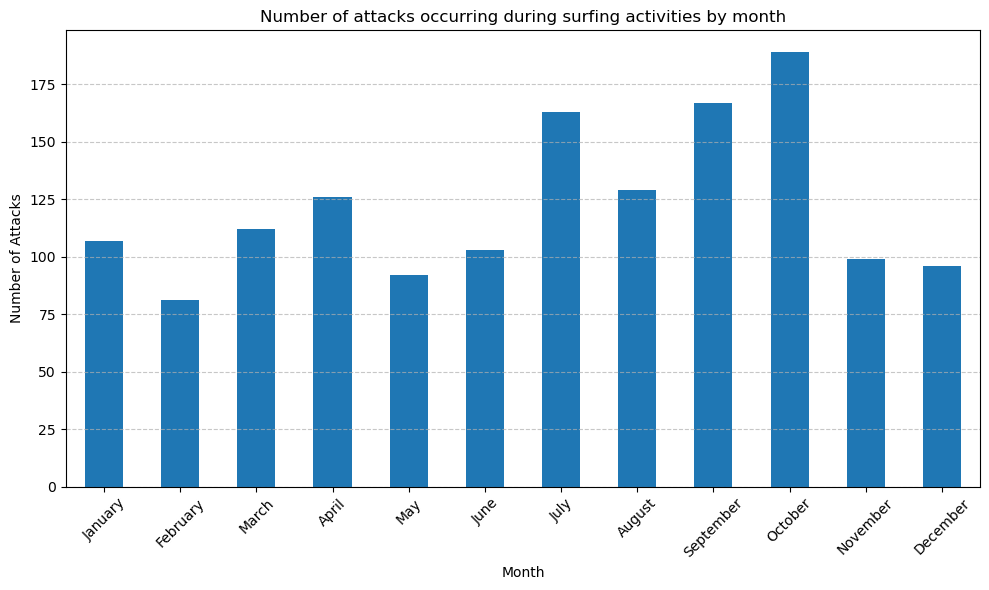

In [44]:
# Create a bar plot to visualize the distribution
plt.figure(figsize=(10, 6))
surfing_by_month.plot(kind='bar')
plt.title('Number of attacks occurring during surfing activities by month')
plt.xlabel('Month')
plt.ylabel('Number of Attacks')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

/var/folders/mg/bhcm044157v8jjlw0q70h74w0000gn/T/ipykernel_14038/1778916571.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  surfing_by_month = filtered_data.groupby('Month').size()


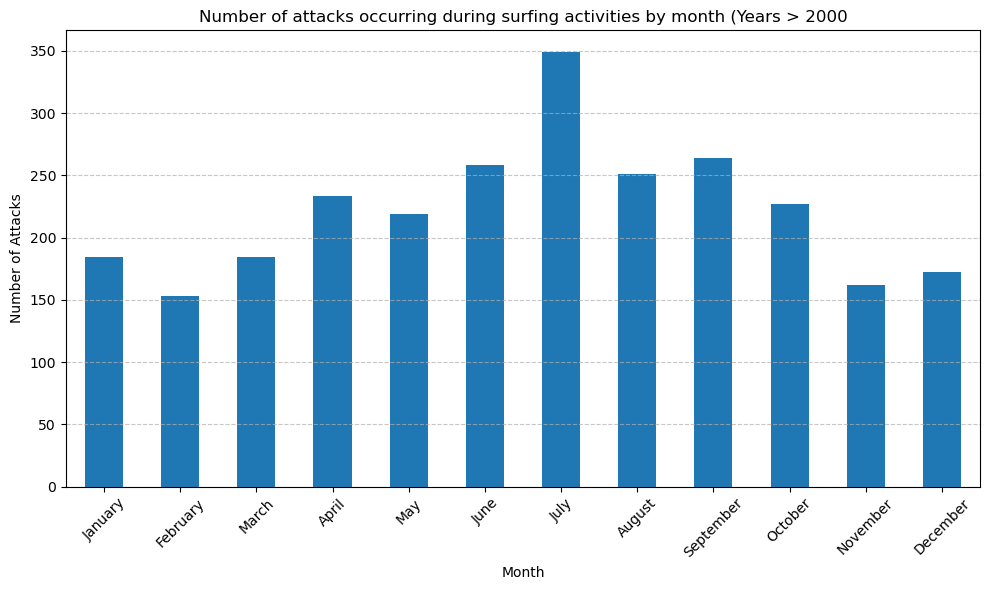

In [45]:
# Filter the dataframe to include only rows where Year > 2000
filtered_data = df[df['Year'] > 2000]

# Group by Month and count activities
surfing_by_month = filtered_data.groupby('Month').size()

# Create a bar plot to visualize the distribution
plt.figure(figsize=(10, 6))
surfing_by_month.plot(kind='bar')
plt.title('Number of attacks occurring during surfing activities by month (Years > 2000')
plt.xlabel('Month')
plt.ylabel('Number of Attacks')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

The following block creates a season column that takes into account the hemisphere of each country. To simplify the process, I created a dictionary the only countries in the southern hemisphere that are included in our dataset. All countries that are not in that dictionary, are auromatically assigned to the northern hemisphere
Afterwards, I added two other dictionaries that include all the key-value pairs of month-season depending on the hemisphere

In [46]:
#southern hemisphere countries (in our dataset)

southern_countries = [
    "Australia", "Brazil", "South Africa", "Papua New Guinea",
    "New Zealand", "Fiji", "New Caledonia", "Réunion",
    "Indonesia", "Chile", "Argentina", "Uruguay", "Madagascar",
    "Samoa", "Vanuatu", "Tonga", "Kiribati"
]

#assign hemisphere

df["Hemisphere"] = df["Country_cleaned"].apply(lambda x: "South" if x in southern_countries else "North")

#map months to seasons for the northern hemisphere

season_map_north = {
    "December": "Winter", "January": "Winter", "February": "Winter",
    "March": "Spring", "April": "Spring", "May": "Spring",
    "June": "Summer", "July": "Summer", "August": "Summer",
    "September": "Autumn", "October": "Autumn", "November": "Autumn"
}

#map months to seasons for the southern hemisphere

season_map_south = {
    "December": "Summer", "January": "Summer", "February": "Summer",
    "March": "Autumn", "April": "Autumn", "May": "Autumn",
    "June": "Winter", "July": "Winter", "August": "Winter",
    "September": "Spring", "October": "Spring", "November": "Spring"
}

#assign seasons

df["Season"] = df.apply(
    lambda row: (
        season_map_south.get(row["Month"]) 
        if row["Hemisphere"] == "South" 
        else season_map_north.get(row["Month"])
    ),
    axis=1
)

df.head()


,Date,Year,Type,Country,State,Location,Activity,Name,Sex,Age,Injury,Fatal Y/N,Time,Species,Source,Country_cleaned,State_cleaned,Fatal Y/N cleaned,Death,Surfing,Death_surf,Month,Hemisphere,Season
0,16th August 2025,2025,Provoked,USA,Florida,Cayo Costa Boca Grande,Fishing,Shawn Meuse,M,?,Laceration to right leg below the knee,N,1055 hrs,Lemon shark 1.8 m (6ft),Johannes Marchand: Kevin McMurray Trackingshar...,United States,Florida,N,0.0,False,0,August,North,Summer
1,18th August,2025,Unprovoked,Australia,NSW,Cabarita Beach,Surfing,Brad Ross,M,?,None sustained board severly damaged,N,0730hrs,5m (16.5ft) Great White,Bob Myatt GSAF The Guardian: 9 News: ABS News:...,Australia,New South Wales,N,0.0,True,0,August,South,Winter
2,17th August,2025,Unprovoked,Bahamas,Atlantic Ocean near Big Grand Cay,North of Grand Bahama near Freeport,Spearfishing,Not stated,M,63,Severe injuries no detail,N,1300hrs,Undetermined,Ralph Collier GSAF and Kevin MCMurray Tracking...,Bahamas,Atlantic Ocean Near Big Grand Cay,N,0.0,False,0,August,North,Summer
3,7th August,2025,Unprovoked,Australia,NSW,Tathra Beach,Surfing,Bowie Daley,M,9,None sustained board severely damaged,N,1630hrs,Suspected Great White,Bob Myatt GSAF,Australia,New South Wales,N,0.0,True,0,August,South,Winter
4,1st August,2025,Unprovoked,Puerto Rico,Carolina,Carolina Beach,Wading,Eleonora Boi,F,39,Bite to thigh area,N,Not stated,Undetermined,Kevin McMurray Trackingsharks.com: NY Post,Puerto Rico,Carolina,N,0.0,False,0,August,North,Summer


Data Visualization: Surfing-related attacks by country and state/region

This pivot table shows the number of surfing attacks per season, taking hemisphere differences into account.
It focuses on the top countries with the highest number of attacks, and within those countries, the top states/regions by attack count

In [47]:
#filter the dataset to include only rows where 'Surfing' is True
df_surf = df[df['Surfing'] == True]

#identify the top countries and top states/regions by number of attacks while surfing
top_countries = df_surf['Country_cleaned'].value_counts().head(10).index
top_state = df_surf['State_cleaned'].value_counts().head(10).index

#keep only entries that are in the top countries and top states/regions
df_top = df_surf[
    (df_surf['Country_cleaned'].isin(top_countries)) & 
    (df_surf['State_cleaned'].isin(top_state))
]

#creating the pivot
pivot = pd.pivot_table(
    df_top,
    values='Surfing',
    index=['Country_cleaned', 'State_cleaned'],
    columns=['Season'],
    aggfunc='count',
    fill_value=0
)

from IPython.display import display
display(pivot)

Season                                 Autumn  Spring  Summer  Winter
Country_cleaned State_cleaned                                        
Australia       New South Wales            38      37      61      27
                South Australia            10       8      10       6
                Western Australia          14      16      12      13
South Africa    Eastern Cape Province      18       9      25      23
                Kwazulu-Natal               7       5      20       3
                Western Cape Province       8       8       5      16
United States   California                 56      18      35      15
                Florida                   203     118     125      32
                Hawaii                     35      31      18      26
                North Carolina              6       1      25       1

Season,Autumn,Spring,Summer,Winter
Country_cleaned,,,,
Australia,78,78,104,65
Brazil,8,8,12,13
French Polynesia,0,2,1,2
Indonesia,2,2,2,1
Mexico,1,5,2,3
New Caledonia,5,1,2,2
New Zealand,4,2,13,0
Réunion,7,1,2,12
South Africa,33,22,51,42


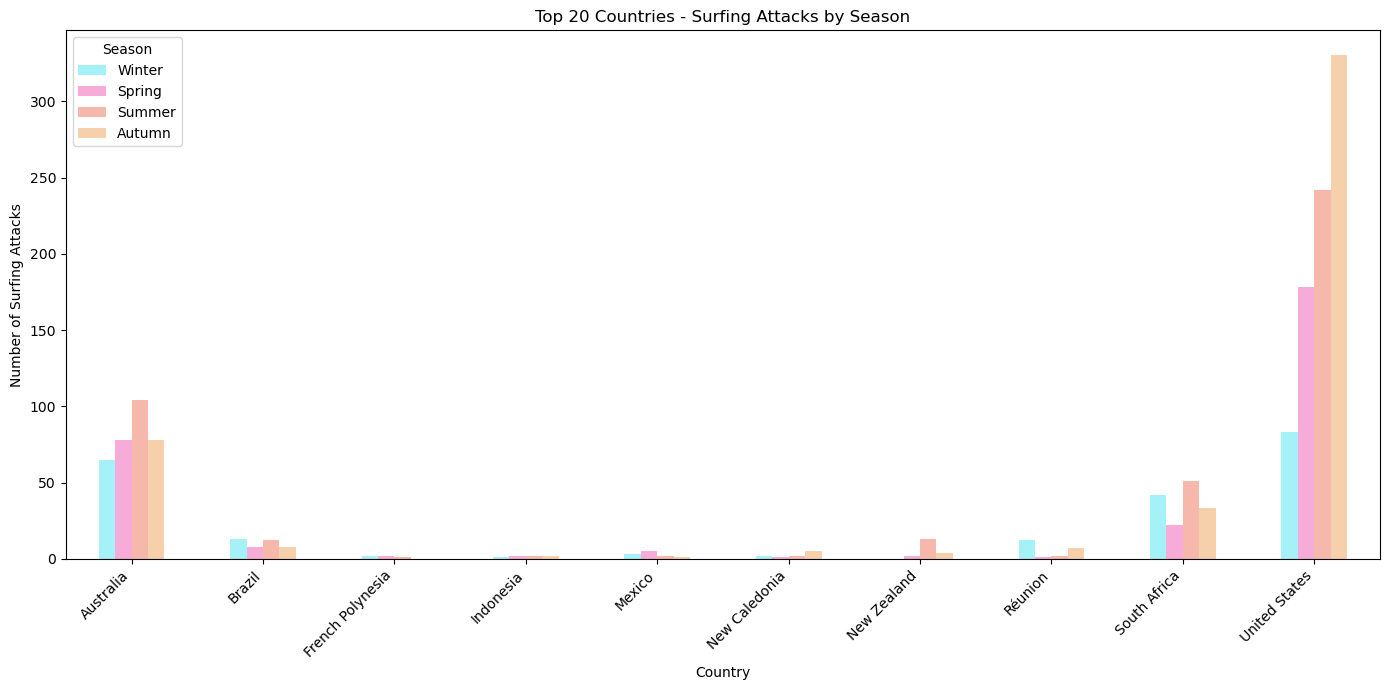

In [48]:
#select the top 10 countries by number of surfing attacks

top_countries = df_surf['Country_cleaned'].value_counts().head(10).index

#filter the dataset to include only rows from the top countries

df_top = df_surf[df_surf['Country_cleaned'].isin(top_countries)]

#create a pivot table showing the number of surfing attacks per season for each top country
#rows: Country, Columns: Season, Values: count of Surfing entries
pivot = pd.pivot_table(
    df_top,
    values='Surfing',
    index=['Country_cleaned'],
    columns=['Season'],
    aggfunc='count',
    fill_value=0
)


#sort countries by total number of attacks (descending)

pivot_sorted = pivot.assign(Total=pivot.sum(axis=1)) \
                    .sort_values(by="Total", ascending=False) \
                    .drop(columns="Total")

display(pivot)

#assign colors to each season
season_colors = {
    'Winter': '#A4F1F8',
    'Spring': '#F6ABD9',
    'Autumn':   '#F6CFAB',
    'Summer': '#F6B8AB'
}

#re-order pivot columns to match season order
pivot = pivot[['Winter', 'Spring', 'Summer', 'Autumn']]

#creating the bar chart
pivot.plot(
    kind='bar',
    figsize=(14,7),
    color=[season_colors[season] for season in pivot.columns]
)

plt.title('Top 20 Countries - Surfing Attacks by Season')
plt.xlabel('Country')
plt.ylabel('Number of Surfing Attacks')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Season')
plt.tight_layout()
plt.show()

In [49]:
#df_filtered = df[
#(df['Country_cleaned'] == 'United States') &
    #(df['State_cleaned'] == 'Florida')
#]

#num_attacks = df_filtered['Surfing'].sum()
#print(num_attacks)

In [50]:
result = df[df['Surfing'] == True].groupby('Season').size()

print(result)

Season
Autumn    477
Spring    308
Summer    448
Winter    231
dtype: int64


In [51]:
print("\n" + "-"*30)
print("DATASET INFO")
print("-"*30)
df.info()

print("\n" + "-"*30)
print("ORIGINAL TIME COLUMN - TOP 20 VALUES")
print("-"*30)
print(df['Time'].value_counts().head(20))

print("\n" + "-"*30)
print("ORIGINAL TIME COLUMN - SUMMARY")
print("-"*30)
print(f"There are {len(df['Time'])} rows in Time.")
print(f"There are {df['Time'].count()} non-null values in Time.")
print(f"There are {df['Time'].isnull().sum()} null values in Time.")

# Convert to string and standardize case
df['Time'] = df['Time'].astype(str).str.strip().str.lower()

# Replace problematic values
df['Time'] = df['Time'].replace(['nan', '', 'unknown', 'not known'], np.nan)


------------------------------
DATASET INFO
------------------------------
<class 'pandas.core.frame.DataFrame'>
Index: 6825 entries, 0 to 7041
Data columns (total 24 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   Date               6825 non-null   object  
 1   Year               6825 non-null   int64   
 2   Type               6808 non-null   object  
 3   Country            6825 non-null   object  
 4   State              6825 non-null   object  
 5   Location           6825 non-null   object  
 6   Activity           6263 non-null   object  
 7   Name               6629 non-null   object  
 8   Sex                6273 non-null   object  
 9   Age                3992 non-null   object  
 10  Injury             6792 non-null   object  
 11  Fatal Y/N          6281 non-null   object  
 12  Time               3466 non-null   object  
 13  Species            3835 non-null   object  
 14  Source             6805 non-null 

In [52]:
# Create a function to standardize hour formats
def standardize_hour_format(time_str):
    if pd.isna(time_str):
        return np.nan
    
    time_str = str(time_str).lower().strip()

    # Identify patterns like 14:23, 14h23, 14.23, 14h, etc.
    hour_patterns = [
        r'(\d{1,2})[:h\.](\d{2})',      # 14:23, 14h23, 14.23
        r'(\d{1,2})h(\d{2})',           # 14h23
        r'(\d{1,2}):(\d{2})',           # 14:23
        r'(\d{1,2})h',                  # 14h
        r'(\d{1,2})\s*pm',              # 2 pm, 2pm
        r'(\d{1,2})\s*am',              # 9 am, 9am
        r'(\d{1,2})\s*:\s*(\d{2})\s*pm', # 2:30 pm
        r'(\d{1,2})\s*:\s*(\d{2})\s*am', # 9:30 am
        r'(\d{2})(\d{2})\s*hrs?',       # 1430 hrs, 1430hr
        r'(\d{2})(\d{2})',              # 1430 (military time)
        r'(\d{1,2})\.(\d{2})',          # 14.30
        r'(\d{1,2})-(\d{2})',           # 14-30
    ]
    #Match patterns to extract hour
    for i, pattern in enumerate(hour_patterns):
        match = re.search(pattern, time_str)
        if match:
            hour = int(match.group(1))
            
            # Handle AM/PM formats
            if 'pm' in pattern and hour != 12:
                hour += 12  # Convert PM to 24-hour format
            elif 'am' in pattern and hour == 12:
                hour = 0    # 12 AM = 00:00
            
            # Handle military time (like 1430 = 14:30)
            if i == 8 or i == 9:  # 1430 hrs or 1430 patterns
                if len(match.group(1)) == 2 and len(match.group(2)) == 2:
                    hour = int(match.group(1))
                    # Don't need minutes, just the hour
            
            # Validate hour range
            if 0 <= hour <= 23:
                return f"{hour:02d}:00"  # Formato HH:00
    
    # Look for standalone numbers (e.g., "9", "14")
    number_match = re.search(r'\b(\d{1,2})\b', time_str)
    if number_match:
        hour = int(number_match.group(1))
        if 0 <= hour <= 23:
            return f"{hour:02d}:00"
    
    return time_str  # Return original if no pattern matched

In [53]:
# Create a function to categorize times (improved with standardized hours)
def categorize_time(time_str):
    if pd.isna(time_str):
        return np.nan
    # Use a standardized time format
    standardized_time = standardize_hour_format(time_str)
    # If we got a standardized hour (HH:00 format), use it for categorization
    if standardized_time and ':' in str(standardized_time):
        try:
            hour = int(standardized_time.split(':')[0])
            # Categorize based on hour ranges
            if 6 <= hour <= 11:
                return 'Morning'
            elif 12 <= hour <= 16:
                return 'Afternoon'
            elif 17 <= hour <= 20:
                return 'Evening'
            elif 21 <= hour <= 23:
                return 'Night'
            elif 0 <= hour <= 5:
                return 'Early Morning'
        except:
            pass  # If parsing fails, continue with text-based categorization
   
    # Fallback to text-based categorization for non-numeric times
    time_str = str(time_str).lower()
    # Morning
    if any(word in time_str for word in ['morning', 'dawn', 'sunrise']):
        return 'Morning'
    # Afternoon
    elif any(word in time_str for word in ['afternoon', 'noon']):
        return 'Afternoon'
    # Evening
    elif any(word in time_str for word in ['evening', 'dusk']):
        return 'Evening'
    # Night
    elif any(word in time_str for word in ['night']):
        return 'Night'
    # Early morning
    elif any(word in time_str for word in ['midnight']):
        return 'Early Morning'
    else:
        return np.nan

In [54]:
# Function to rescue other time data
def rescue_time_data(time_str):
    if pd.isna(time_str):
        return np.nan
    time_str = str(time_str).lower().strip()
    
    # Rescue patterns
    import re
    
    # Identify various descriptive patterns
    rescue_patterns = [
        # Create patterns to capture ranges and approximate times
        (r'between\s+(\d{1,2})', 'range_start'),
        (r'(\d{1,2})\s*-\s*(\d{1,2})\s*h', 'range_middle'),
        (r'around\s+(\d{1,2})', 'approximate'),
        (r'about\s+(\d{1,2})', 'approximate'),
        (r'near\s+(\d{1,2})', 'approximate'),
        
        # Extract specific descriptive times of day
        (r'early\s+morning', 'early_morning_text'),
        (r'late\s+morning', 'late_morning_text'),
        (r'early\s+afternoon', 'early_afternoon_text'),
        (r'late\s+afternoon', 'late_afternoon_text'),
        (r'early\s+evening', 'early_evening_text'),
        (r'late\s+evening', 'late_evening_text'),
        
        # Other general descriptors
        (r'am\s*$', 'morning_general'),  # Solo "am"
        (r'pm\s*$', 'afternoon_general'), # Solo "pm"
        (r'midday', 'noon_text'),
        (r'noon', 'noon_text'),
        (r'sunrise', 'sunrise_text'),
        (r'sunset', 'sunset_text'),
        (r'twilight', 'twilight_text'),
        (r'daylight', 'daylight_text'),
        (r'daybreak', 'daybreak_text'),
    ]
    
    for pattern, category in rescue_patterns:
        match = re.search(pattern, time_str)
        if match:
            if category == 'range_start' or category == 'range_middle' or category == 'approximate':
                hour = int(match.group(1))
                if 0 <= hour <= 23:
                    return f"{hour:02d}:00"
            
            # Mappings for descriptive times
            time_mappings = {
                'early_morning_text': '06:00',
                'late_morning_text': '10:00',
                'early_afternoon_text': '13:00',
                'late_afternoon_text': '16:00',
                'early_evening_text': '18:00',
                'late_evening_text': '20:00',
                'morning_general': '09:00',
                'afternoon_general': '14:00',
                'noon_text': '12:00',
                'sunrise_text': '06:00',
                'sunset_text': '19:00',
                'twilight_text': '20:00',
                'daylight_text': '12:00',
                'daybreak_text': '06:00',
            }
            
            if category in time_mappings:
                return time_mappings[category]
    
    return time_str

# Include rescued time data before categorization
df['Time_Rescued'] = df['Time'].apply(rescue_time_data)

# Create a Time_Clean column using the categorize_time function
df['Time_Clean'] = df['Time_Rescued'].apply(categorize_time)

print("\n" + "="*50)
print("TIME_CLEAN COLUMN - FINAL RESULTS")
print("="*50)
print(df['Time_Clean'].value_counts().head(20))

print("\n" + "-"*30)
print("SUMMARY STATISTICS")
print("-"*30)
print(f"There are {len(df['Time_Clean'])} rows in Time_Clean.")
print(f"There are {df['Time_Clean'].count()} non-null values in Time_Clean.")
print(f"There are {df['Time_Clean'].isnull().sum()} null values in Time_Clean.")
print("="*50)

print("\n" + "="*50)
print("TIME OF DAY DISTRIBUTION - BAR CHART")
print("="*50)


TIME_CLEAN COLUMN - FINAL RESULTS
Time_Clean
Afternoon        1591
Morning          1101
Evening           532
Night              87
Early Morning      76
Name: count, dtype: int64

------------------------------
SUMMARY STATISTICS
------------------------------
There are 6825 rows in Time_Clean.
There are 3387 non-null values in Time_Clean.
There are 3438 null values in Time_Clean.

TIME OF DAY DISTRIBUTION - BAR CHART


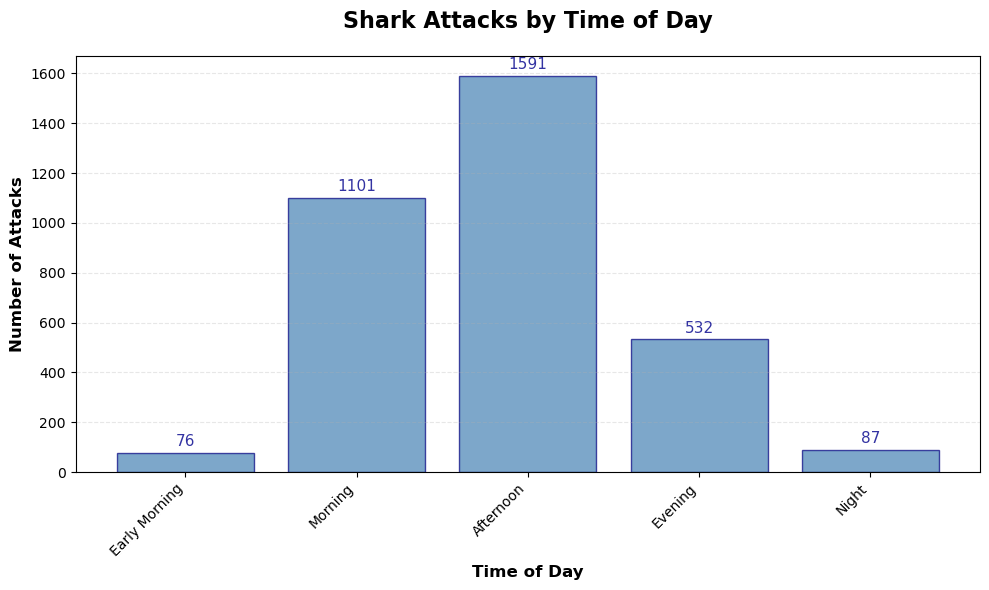


Total attacks with time data: 3387

SURFING ACTIVITIES FILTER
Total records: 6825
Surfing-related records: 1495
Percentage of surfing activities: 21.9%

------------------------------
SURFING ACTIVITIES - TOP VALUES
------------------------------
Activity
Surfing                    1134
Body surfing                 50
Windsurfing                  20
Surf fishing                 14
Surf-skiing                  13
Surf skiing                  12
Surf skiing                  12
Paddle boarding              11
Sitting on surfboard          9
Stand-Up Paddleboarding       9
Name: count, dtype: int64

------------------------------
SURFING ACTIVITIES - TIME DISTRIBUTION
------------------------------
Time_Clean
Afternoon        486
Morning          441
Evening          201
Early Morning     12
Night              4
Name: count, dtype: int64

------------------------------
SURFING TIME_CLEAN - DETAILED STATISTICS
------------------------------
There are 1495 rows in Surfing Time_Clean.
There 

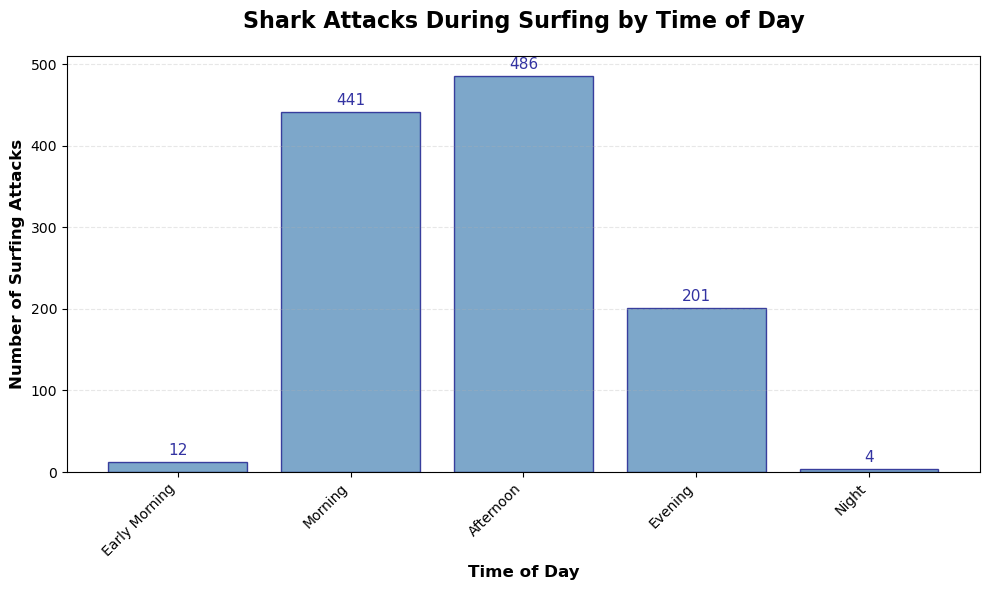


Total surfing attacks with time data: 1144

SURFING ATTACKS - EXACT HOUR ANALYSIS
Surfing records with exact hour data (HH:MM): 75
Surfing records without exact hour data: 1420

------------------------------
TOP 10 EXACT HOURS FOR SURFING ATTACKS
------------------------------
12:00 - 40 attack(s)
16:00 - 9 attack(s)
19:00 - 8 attack(s)
06:00 - 6 attack(s)
00:00 - 3 attack(s)
14:00 - 2 attack(s)
09:00 - 2 attack(s)
13:00 - 2 attack(s)
15:00 - 1 attack(s)
05:00 - 1 attack(s)

------------------------------
MOST DANGEROUS HOUR FOR SURFERS
------------------------------
🚨 PEAK DANGER TIME: 12:00
📊 Number of attacks: 40
⚠️  Risk level: 53.3% of all timed surfing attacks
🕐 Time period: Afternoon


In [55]:
# Define the chronological order
chronological_order = ['Early Morning', 'Morning', 'Afternoon', 'Evening', 'Night']

# Obtain counts for each time category
time_counts = df['Time_Clean'].value_counts()

# Create ordered lists for the chart
ordered_times = []
ordered_counts = []

for time_period in chronological_order:
    if time_period in time_counts.index:
        ordered_times.append(time_period)
        ordered_counts.append(time_counts[time_period])

# Create the chart
plt.figure(figsize=(10, 6))
bars = plt.bar(ordered_times, ordered_counts, color='steelblue', alpha=0.7, edgecolor='navy', linewidth=1)

# Add value labels on top of bars
for bar, count in zip(bars, ordered_counts):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(ordered_counts)*0.01, 
             str(count), ha='center', va='bottom', fontsize=11, color='darkblue', alpha=0.8)

# Customize the chart
plt.title('Shark Attacks by Time of Day', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Time of Day', fontsize=12, fontweight='bold')
plt.ylabel('Number of Attacks', fontsize=12, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3, linestyle='--')

# Adjust layout and show
plt.tight_layout()
plt.show()

print(f"\nTotal attacks with time data: {sum(ordered_counts)}")
print("="*50)

print("\n" + "="*50)
print("SURFING ACTIVITIES FILTER")
print("="*50)

# Filter for surfing-related activities
surfing_keywords = ['surf', 'surfboard', 'surfer', 'surfing', 'wave', 'paddle']

# Create mask to filter rows with surfing activities
surfing_mask = df['Activity'].str.lower().str.contains('|'.join(surfing_keywords), na=False, regex=True)
surfing_data = df[surfing_mask].copy()

print(f"Total records: {len(df)}")
print(f"Surfing-related records: {len(surfing_data)}")
print(f"Percentage of surfing activities: {len(surfing_data)/len(df)*100:.1f}%")

print("\n" + "-"*30)
print("SURFING ACTIVITIES - TOP VALUES")
print("-"*30)
print(surfing_data['Activity'].value_counts().head(10))

print("\n" + "-"*30)
print("SURFING ACTIVITIES - TIME DISTRIBUTION")
print("-"*30)
surfing_time_counts = surfing_data['Time_Clean'].value_counts()
print(surfing_time_counts)

print("\n" + "-"*30)
print("SURFING TIME_CLEAN - DETAILED STATISTICS")
print("-"*30)
print(f"There are {len(surfing_data['Time_Clean'])} rows in Surfing Time_Clean.")
print(f"There are {surfing_data['Time_Clean'].count()} non-null values in Surfing Time_Clean.")
print(f"There are {surfing_data['Time_Clean'].isnull().sum()} null values in Surfing Time_Clean.")
print("="*50)

print("\n" + "="*50)
print("SURFING ATTACKS - TIME OF DAY DISTRIBUTION BAR CHART")
print("="*50)

# Define the chronological order (same as before)
chronological_order = ['Early Morning', 'Morning', 'Afternoon', 'Evening', 'Night']

# Obtain counts for each time category in surfing data
surfing_time_counts = surfing_data['Time_Clean'].value_counts()

# Create ordered lists for the surfing chart
surfing_ordered_times = []
surfing_ordered_counts = []

for time_period in chronological_order:
    if time_period in surfing_time_counts.index:
        surfing_ordered_times.append(time_period)
        surfing_ordered_counts.append(surfing_time_counts[time_period])

# Create the surfing chart
plt.figure(figsize=(10, 6))
bars = plt.bar(surfing_ordered_times, surfing_ordered_counts, color='steelblue', alpha=0.7, edgecolor='navy', linewidth=1)

# Add value labels on top of bars
for bar, count in zip(bars, surfing_ordered_counts):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(surfing_ordered_counts)*0.01, 
             str(count), ha='center', va='bottom', fontsize=11, color='darkblue', alpha=0.8)

# Customize the surfing chart
plt.title('Shark Attacks During Surfing by Time of Day', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Time of Day', fontsize=12, fontweight='bold')
plt.ylabel('Number of Surfing Attacks', fontsize=12, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3, linestyle='--')

# Adjust layout and show
plt.tight_layout()
plt.show()

print(f"\nTotal surfing attacks with time data: {sum(surfing_ordered_counts)}")
print("="*50)

print("\n" + "="*50)
print("SURFING ATTACKS - EXACT HOUR ANALYSIS")
print("="*50)

# Filter surfing records with exact hour data (HH:MM format)
surfing_exact_hours = surfing_data[surfing_data['Time_Rescued'].str.contains(r'\d{2}:\d{2}', na=False, regex=True)]

print(f"Surfing records with exact hour data (HH:MM): {len(surfing_exact_hours)}")
print(f"Surfing records without exact hour data: {len(surfing_data) - len(surfing_exact_hours)}")

if len(surfing_exact_hours) > 0:
    print("\n" + "-"*30)
    print("TOP 10 EXACT HOURS FOR SURFING ATTACKS")
    print("-"*30)

    # Count the most frequent exact hours
    exact_hour_counts = surfing_exact_hours['Time_Rescued'].value_counts().head(10)
    
    for hour, count in exact_hour_counts.items():
        print(f"{hour} - {count} attack(s)")
    
    print("\n" + "-"*30)
    print("MOST DANGEROUS HOUR FOR SURFERS")
    print("-"*30)
    
    if len(exact_hour_counts) > 0:
        most_dangerous_hour = exact_hour_counts.index[0]
        most_dangerous_count = exact_hour_counts.iloc[0]
        
        print(f"🚨 PEAK DANGER TIME: {most_dangerous_hour}")
        print(f"📊 Number of attacks: {most_dangerous_count}")
        print(f"⚠️  Risk level: {most_dangerous_count/len(surfing_exact_hours)*100:.1f}% of all timed surfing attacks")
        
        # Show the time period for the most dangerous hour
        danger_hour_int = int(most_dangerous_hour.split(':')[0])
        if 6 <= danger_hour_int <= 11:
            period = "Morning"
        elif 12 <= danger_hour_int <= 16:
            period = "Afternoon"
        elif 17 <= danger_hour_int <= 20:
            period = "Evening"
        elif 21 <= danger_hour_int <= 23:
            period = "Night"
        else:
            period = "Early Morning"
            
        print(f"🕐 Time period: {period}")
    
else:
    print("\n⚠️  No exact hour data (HH:MM format) found for surfing attacks.")
    print("Analysis limited to general time periods only.")

print("="*50)


In [56]:
#drop old columns
columns_to_drop = ["Date", "Country", "State", "Time"]
df = df.drop(columns=columns_to_drop, errors="ignore")

#re-order columns
new_order = ["Year", "Month", "Time_Rescued", "Time_Clean", "Hemisphere", "Season", "Country_cleaned", "State_cleaned", "Location", "Activity", "Surfing", "Injury", "Fatal Y/N cleaned", "Death", "Name", "Sex", "Age", "Type"]  
df = df[new_order]

In [57]:
df.to_csv("cleaned_states.csv", index=False, encoding="utf-8")